In [32]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 3GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3072)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [33]:
class FFN(tf.keras.Model):

    def __init__(self):
        super(FFN, self).__init__()

        self.layer_list=[
        tf.keras.layers.Dense(256, tf.nn.relu) ,
        tf.keras.layers.Dense(128, tf.nn.relu),
        tf.keras.layers.Dense(128, tf.nn.relu),
        tf.keras.layers.Dense(64, tf.nn.relu),
        tf.keras.layers.Dense(32, tf.nn.relu),
        tf.keras.layers.Dense(16, tf.nn.relu),
        tf.keras.layers.Dense(10, tf.nn.softmax) # output layer with 10 neurons due to our dataset
        ]


    @tf.function
    def call(self,inputs):

        x = inputs
        for layer in self.layer_list:
            x = layer(x)

        return x 

def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function):
    # test over complete test data
    test_accuracy_aggregator = [] # binary: did we predict the target, yes or no?
    test_loss_aggregator = []     # continous: how far away are we from the target? 

    for (input, target) in test_data:
        prediction = model(input) # calculate prediction
        sample_test_loss = loss_function(target, prediction) # calculate loss w.r.t target
        sample_test_accuracy = np.argmax(target, axis = 1) == np.argmax(prediction, axis = 1) # compares if maximum value is at the same index (one-hot), return 0 or 1
        sample_test_accuracy = np.mean(sample_test_accuracy) # takes mean of compairisons
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

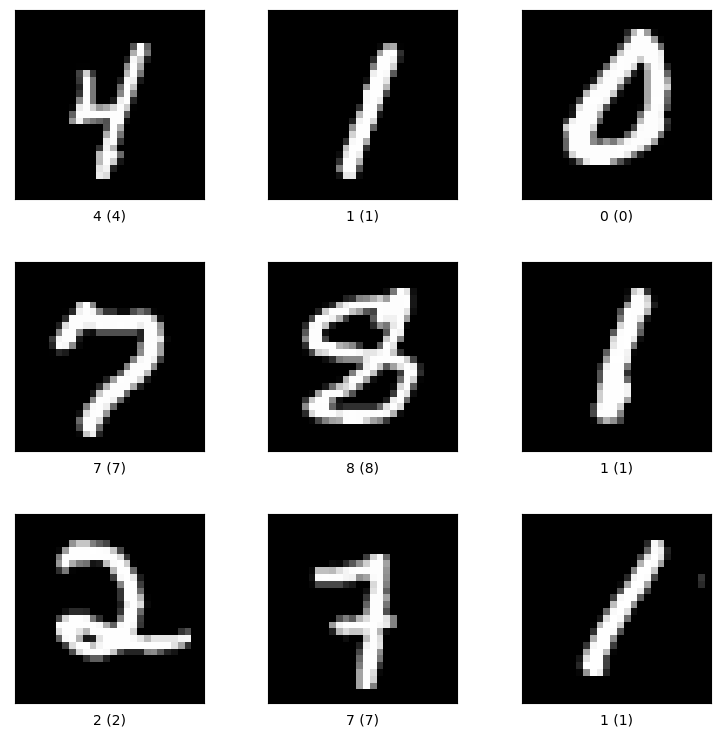

In [34]:
# creating data pipeline to change data accordingly
(train_ds, val_ds), ds_info = tfds.load("mnist", split=["train", "test"], as_supervised=True, with_info = True)

tfds.show_examples(train_ds, ds_info)

train_ds = train_ds.map(lambda img, target: ((tf.cast(tf.reshape(img, (-1,)), tf.float32)/128.)-1., tf.one_hot(target, 10, dtype=tf.float32)),\
                        num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(5000).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(lambda img, target: ((tf.cast(tf.reshape(img, (-1,)), tf.float32)/128.)-1., tf.one_hot(target, 10, dtype=tf.float32)),\
                    num_parallel_calls=tf.data.AUTOTUNE).cache().batch(32).prefetch(tf.data.AUTOTUNE)


In [35]:
tf.keras.backend.clear_session()

# initialize model
model = FFN()

# set the hyperparameters
n_epochs = 10
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_function = tf.keras.losses.CategoricalCrossentropy()

# lists for visualization
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# test once before beginning
test_loss, test_accuracy = test(model, val_ds, loss_function)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
print(f'performance on test data before training: accuracy: {test_accuracies[-1]} loss: {test_losses[-1]}')


# check how model performs on train data before training
train_loss, train_accuracy = test(model, train_ds, loss_function)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)
print(f'performance on training data before training: accuracy: {train_accuracies[-1]} loss: {train_losses[-1]}')

# training loop
for epoch in range(n_epochs):
    print(f'Epoch: {str(epoch)} starting with test data accuracy: {test_accuracies[-1]} test data loss: {test_losses[-1]}')

    epoch_loss_aggregator = []
    # training in person
    for input, target in train_ds:
        train_loss = train_step(model, input, target, loss_function, optimizer)
        epoch_loss_aggregator.append(train_loss)
    
    train_losses.append(tf.reduce_mean(epoch_loss_aggregator))

    test_loss, test_accuracy = test(model, val_ds, loss_function)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
print(f'final test data accuracy: {test_accuracies[-1]} final test data loss: {test_losses[-1]}')

performance on test data before training: accuracy: 0.11611421725239617 loss: 2.310971260070801
performance on training data before training: accuracy: 0.1129 loss: 2.310988187789917
Epoch: 0 starting with test data accuracy: 0.11611421725239617 test data loss: 2.310971260070801
Epoch: 1 starting with test data accuracy: 0.9299121405750799 test data loss: 0.23400135338306427
Epoch: 2 starting with test data accuracy: 0.9460862619808307 test data loss: 0.1746830940246582
Epoch: 3 starting with test data accuracy: 0.9583666134185304 test data loss: 0.14086270332336426
Epoch: 4 starting with test data accuracy: 0.9617611821086262 test data loss: 0.13170014321804047
Epoch: 5 starting with test data accuracy: 0.9652555910543131 test data loss: 0.12015119940042496


KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

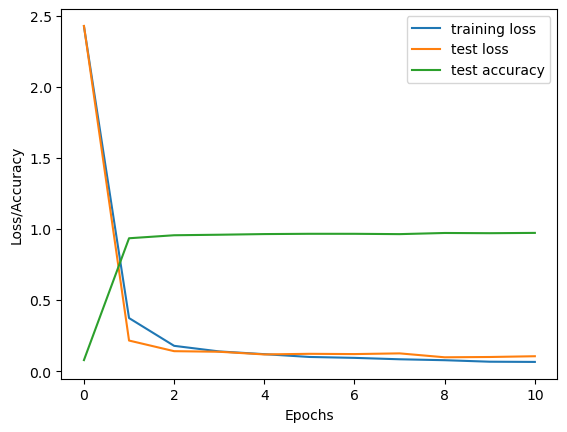

In [ ]:
# plot the training
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3), ("training loss", "test loss", "test accuracy"))
plt.show

In [ ]:
# results
# setup 1
# hyperparameter : n_epochs = 10; learning_rate = 0.001; FNN with 2 hidden layers, 256, 256; optimizer = tf.keras.optimizers.SGD(); loss_function = tf.keras.losses.CategoricalCrossentropy()
# final test data accuracy: 0.928314696485623 final test data loss: 0.25687554478645325
# time 6m 4.7s

# setup 2
# hyperparameter : n_epochs = 10; learning_rate = 0.001; FNN with 2 hidden layers, 256, 256; optimizer = tf.keras.optimizers.Adam(); loss_function = tf.keras.losses.CategoricalCrossentropy()
# final test data accuracy: 0.9693490415335463 final test data loss: 0.12137551605701447
# time 6m 48.1s

# setup 3
# hyperparameter : n_epochs = 15; learning_rate = 0.001; FNN with 2 hidden layers, 16, 16; optimizer = tf.keras.optimizers.Adam(); loss_function = tf.keras.losses.CategoricalCrossentropy()
# after 10 epochs: test data accuracy: 0.9352036741214057 test data loss: 0.2155255675315857
# final test data accuracy: 0.9369009584664537 final test data loss: 0.2078908383846283
# time 12m 47.6s

# setup 4
# hyperparameter : n_epochs = 10; learning_rate = 0.001; FNN with 4 hidden layers, 64, 32, 32, 16; optimizer = tf.keras.optimizers.Adam(); loss_function = tf.keras.losses.CategoricalCrossentropy()
# final test data accuracy: 0.966952875399361 final test data loss: 0.10898780077695847
# time 8m 21.7s

# setup 5
# hyperparameter : n_epochs = 10; learning_rate = 0.001; FNN with 6 hidden layers, 256, 128, 128, 64, 32, 16; optimizer = tf.keras.optimizers.Adam(); loss_function = tf.keras.losses.CategoricalCrossentropy()
# final test data accuracy: 0.9731429712460063 final test data loss: 0.10500059276819229
# time 10m 3.6s